### **MÓDULO 3: PUSH NOTIFICATIONS CON MODELO LINEAL** 

En este documento se muestra el proceso de experimentación llevado a cabo para la obtención del primer modelo lineal que servirá como baseline para el problema de negocio de las push notifications. 
Se realizará el split de los datos y el entrenamiento de diferentes modelos, escogiendo uno como modelo final para la implementación del MVP 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

/mnt/d/Escritorio/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


En primer lugar, debido a que los datos se corresponden con históricos de compras, se ordenan las filas del dataset de mayor a menor antigüedad. 

In [ ]:
def filter_data(df: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    filtered_df = df.loc[df.groupby('order_id').filter(lambda x: (x.outcome == 1).sum() >= min_items).index]
    return filtered_df

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.sort_values(by='created_at')
    
    return df

data_path = '../data/feature_frame.csv' 
df = pd.read_csv(data_path) 
data = filter_data(df) 
data = format_dataframe(data)

Text(0.5, 1.0, 'Number of Orders Over Time')

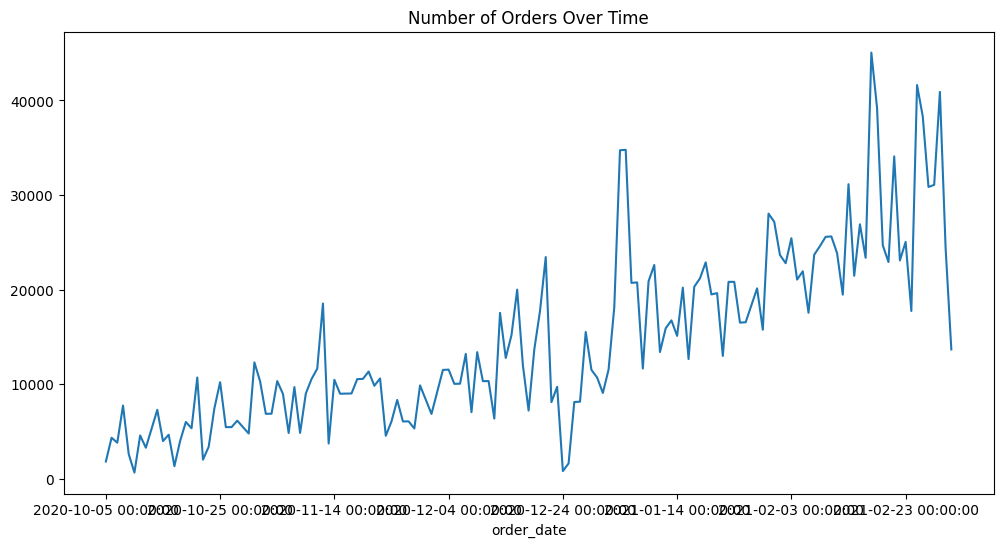

In [3]:
plt.figure(figsize=(12,6))
data.groupby('order_date').count()['order_id'].plot() 
plt.title("Number of Orders Over Time") 

Cuando el modelo esté en producción, se habrá entrenado con datos pasados y se enfrentará a datos futuros nunca vistos. Si se realizara un split de los datos aleatorios que cogiera un 70% de las filas para entrenar y un 30% para validación/test, el modelo se entrenaría y validaría con datos pertenecientes a la misma franja temporal. Es decir, el modelo habría visto en train datos de días que luego volverá a ver en validación/test, por lo que el modelo estaría viendo información del futuro en el entrenamiento (**information leakage**). Para evitar esto, se realizará un _temporal split_, de tal forma que se empleará aproximadamente el primer 70% de los datos para entrenamiento, el siguiente 20% para validación y el siguiente 10% para test. 

In [4]:
def train_test_val_split(df: pd.DataFrame, train_size: float = 0.7, val_size: float = 0.2, test_size: float = 0.1
                         ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]: 
    n = len(df) 

    potential_train_rows = df[:int(n * train_size)]
    train_th_day = potential_train_rows['order_date'].iloc[-1]
    train_data = df[df['order_date'] <= train_th_day]
    y_train = train_data['outcome']
    x_train = train_data.drop(columns=['outcome'])

    potential_val_rows = df[int(n * train_size):int(n * (train_size + val_size))]
    val_th_day = potential_val_rows['order_date'].iloc[-1]
    val_data = df[(df['order_date'] > train_th_day) & (df['order_date'] <= val_th_day)]
    y_val = val_data['outcome']
    x_val = val_data.drop(columns=['outcome'])

    test_data = df[df['order_date'] > val_th_day]
    y_test = test_data['outcome']
    x_test = test_data.drop(columns=['outcome'])

    return x_train, x_val, x_test, y_train, y_val, y_test

Para los primeros modelos se prescindirá de las variables categóricas, quedándonos solo con las variables numéricas. De esta forma, se obtendrán unos primeros modelos sencillos que luego puedan servir para comparar posteriores adiciones de las variables categóricas con diferentes codificaciones. 

In [5]:
def apply_common_transformations(df: pd.DataFrame) -> pd.DataFrame: 
    df.drop(columns=['variant_id', 'order_id', 'user_id', 'created_at', 'order_date'], inplace=True)

    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    categorical_cols = [col for col in df.select_dtypes(include='object').columns if col not in binary_cols]
    numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in binary_cols and col not in categorical_cols]

    return df, binary_cols, categorical_cols, numerical_cols 

x_train, x_val, x_test, y_train, y_val, y_test = train_test_val_split(data)

x_train, binary_cols, categorical_cols, numerical_cols = apply_common_transformations(x_train) 
x_val, _, _, _ = apply_common_transformations(x_val)
x_test, _, _, _ = apply_common_transformations(x_test)


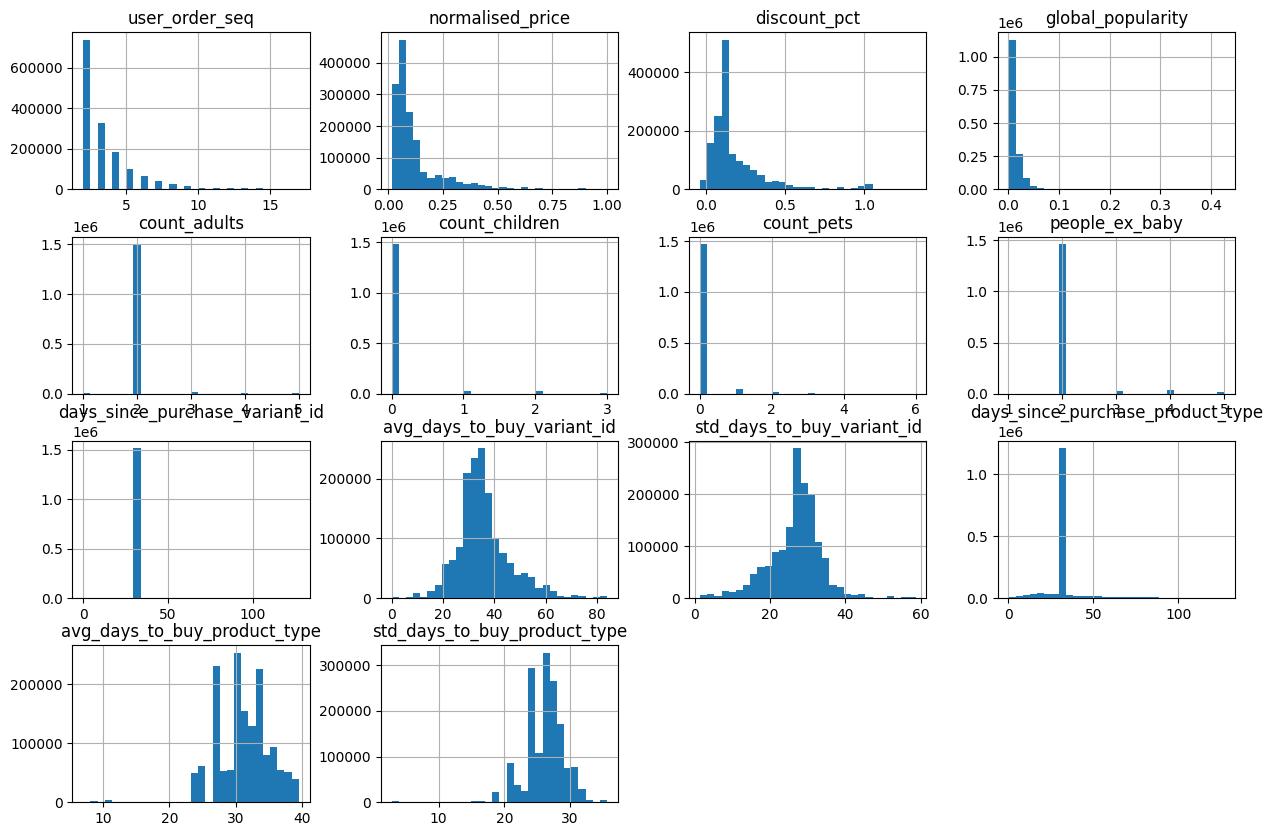

In [6]:
x_train[numerical_cols].hist(bins=30, figsize=(15,10))
plt.show() 

En los histogramas se observa que hay variables cuyas distribuciones se asemejan a una delta de Dirac. Puesto que la gran mayoría de registros de estas variables presentan el mismo valor, se prescindirá de ellas para estos modelos, pues a primera vista parece que no van a aportar demasiado (y además queremos que el baseline sea relativamente sencillo). En cuanto al resto de variables, con el objetivo de garantizar la estabilidad numérica y los órdenes de magnitud de los pesos, se realizará un escalado de los datos. Para ello, se probarán dos tipos de escaladores: `StandardScaler`y `MinMaxScaler`. 

In [7]:
x_train.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                      'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_val.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                    'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_test.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                     'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)

x_train.drop(columns=categorical_cols, inplace=True)
x_val.drop(columns=categorical_cols, inplace=True)
x_test.drop(columns=categorical_cols, inplace=True) 

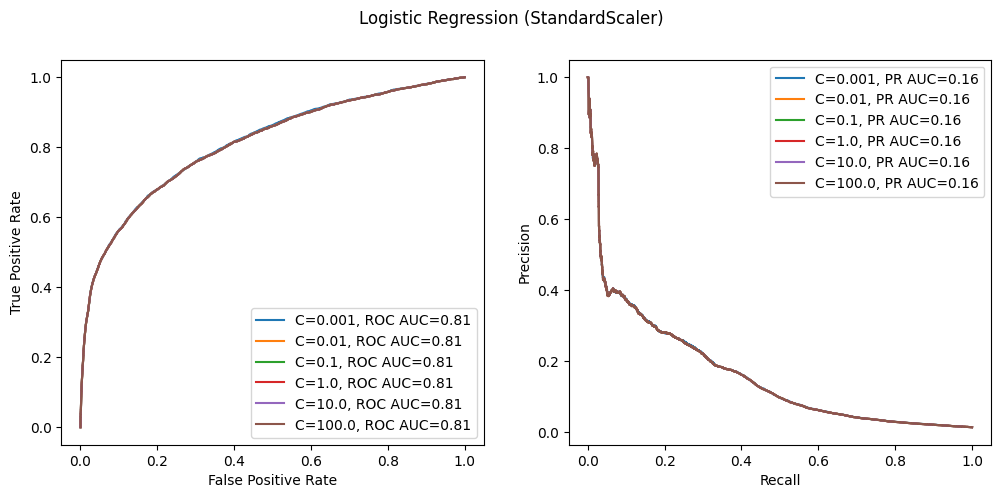

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, auc 

def create_pipeline(c: float) -> Pipeline: 
    model = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('classifier', LogisticRegression(C=c))
    ])
    return model

C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 

plt.figure(figsize=(12,5))
for c in C: 
    model = create_pipeline(c)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"C={c}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"C={c}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Logistic Regression (StandardScaler)")
plt.show() 

Los resultados muestran que el rendimiento del modelo es prácticamente el mismo independientemente de la regularización aplicada. Esto es debido a que cuanto mayor es el tamaño del conjunto de datos, menor es la regularización necesaria, pues se cuenta con más datos para poder estimar correctamente la función subyacente al problema, que es lo que se persigue realmente cuando se trabaja con Machine Learning. 

Un aspecto importante a tener en cuenta es que el dataset está enormemente desbalanceado: únicamente el 1.15% de los datos pertenecen a la clase positiva. La curva ROC es insensible al desbalanceo, por lo que los resultados obtenidos en dichas curvas no son fiables. Se deberá analizar la curva Precision-Recall para poder realizar una buena comparación entre los modelos. Sin embargo, la zona de la izquierda de la curva Precision-Recall tampoco es fiable, pero esto es debido a la alta volatilidad que hay en el cálculo de la precisión. La precisión se calcula como $\dfrac{TP}{TP+FP}$. En la parte izquierda de la gráfica, un recall muy bajo indica que se detectan muy pocos casos positivos, por lo que el umbral es muy alto. Como se detectan muy pocos casos positivos, ${TP+FP}$ es muy bajo, por lo que un +1 en TP hace que el resultado de la fracción cambie mucho, de ahí la volatilidad de esa parte de la curva. De cara al análisis de esta curva, se omitirá la parte más a la izquierda, y nos centraremos en la parte del medio y de la derecha. 

Text(0.5, 0.98, 'Logistic Regression (MinMaxScaler)')

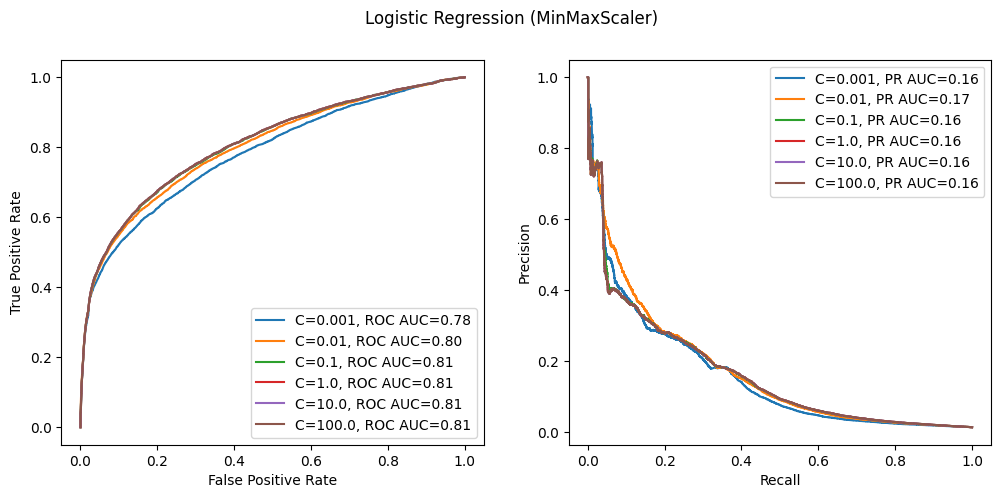

In [9]:
def create_pipeline(c: float) -> Pipeline: 
    model = Pipeline(steps=[
        ('scaler', MinMaxScaler()), 
        ('classifier', LogisticRegression(C=c))
    ])
    return model

C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 

plt.figure(figsize=(12,5))
for c in C: 
    model = create_pipeline(c)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"C={c}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"C={c}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Logistic Regression (MinMaxScaler)")

Al utilizar `MinMaxScaler`, el comportamiento del modelo es ligeramente diferente en función de la regularización, pero prácticamente inapreciable. La razón es la misma que con los anteriores modelos. 

De entre todos los modelos probados hasta ahora, el que mejor valor AUC tiene en la curva Precision-Recall es el que usa MinMaxScaler con C=0.01. Se escogerá ese modelo como potencial baseline de esta ronda de pruebas. 

A continuación se probará a incluir las variables categóricas (`product_type` y `vendor`) codificadas mediante Target Encoding. 

In [11]:
from sklearn.preprocessing import TargetEncoder 

def filter_data(df: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    filtered_df = df.loc[df.groupby('order_id').filter(lambda x: (x.outcome == 1).sum() >= min_items).index]
    return filtered_df

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.sort_values(by='created_at')
    
    return df

data_path = '../data/feature_frame.csv' 
df = pd.read_csv(data_path) 
data = filter_data(df) 
data = format_dataframe(data)

x_train, x_val, x_test, y_train, y_val, y_test = train_test_val_split(data)

x_train, binary_cols, categorical_cols, numerical_cols = apply_common_transformations(x_train) 
x_val, _, _, _ = apply_common_transformations(x_val)
x_test, _, _, _ = apply_common_transformations(x_test)

x_train.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                      'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_val.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                    'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_test.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                     'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)

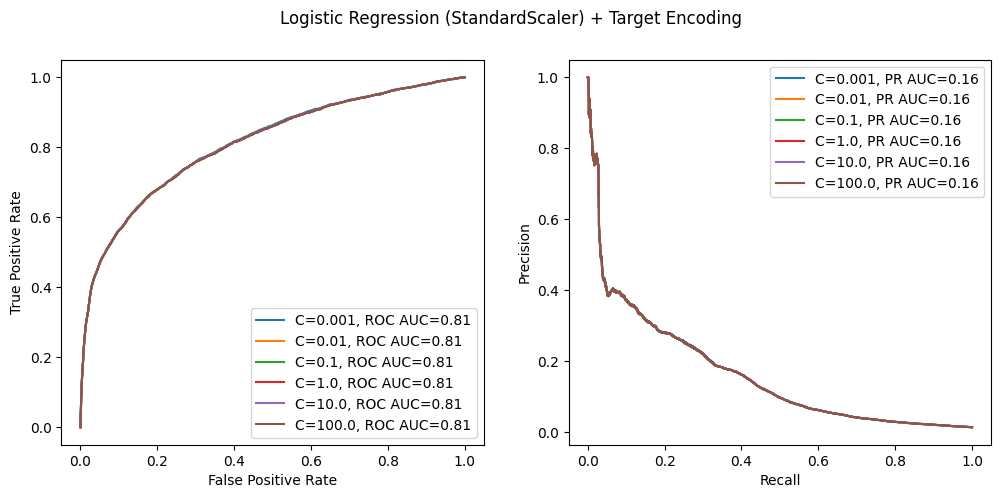

In [13]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector

def create_pipeline(c: float) -> Pipeline: 
    numerical_pipe = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    categorical_pipe = Pipeline(steps=[
        ('encoder', TargetEncoder())
    ]) 

    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipe, selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_pipe, selector(dtype_include='object'))
    ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=c))
    ])
    return model

C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 

plt.figure(figsize=(12,5))
for c in C: 
    model = create_pipeline(c)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"C={c}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"C={c}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Logistic Regression (StandardScaler) + Target Encoding")
plt.show() 

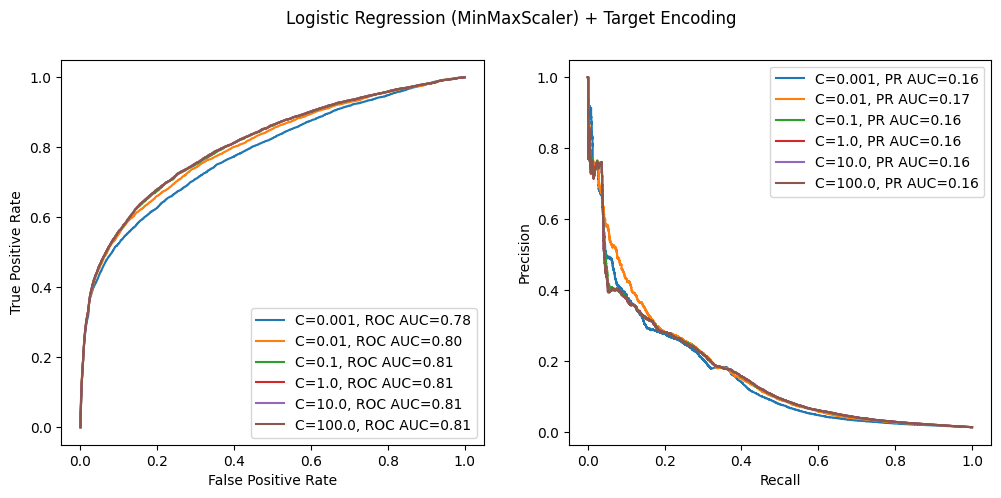

In [14]:
def create_pipeline(c: float) -> Pipeline: 
    numerical_pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])
    categorical_pipe = Pipeline(steps=[
        ('encoder', TargetEncoder())
    ]) 

    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipe, selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_pipe, selector(dtype_include='object'))
    ])

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=c))
    ])
    return model

C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 

plt.figure(figsize=(12,5))
for c in C: 
    model = create_pipeline(c)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"C={c}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"C={c}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Logistic Regression (MinMaxScaler) + Target Encoding")
plt.show() 

Los resultados obtenidos incluyendo las variables categóricas son iguales que los obtenidos únicamente con variables numéricas. Por tanto, el modelo escogido como baseline para este MVP es 
#### **Regresión Logística (C=0.01) con `MinMaxScaler` con las variables numéricas como entrada** 

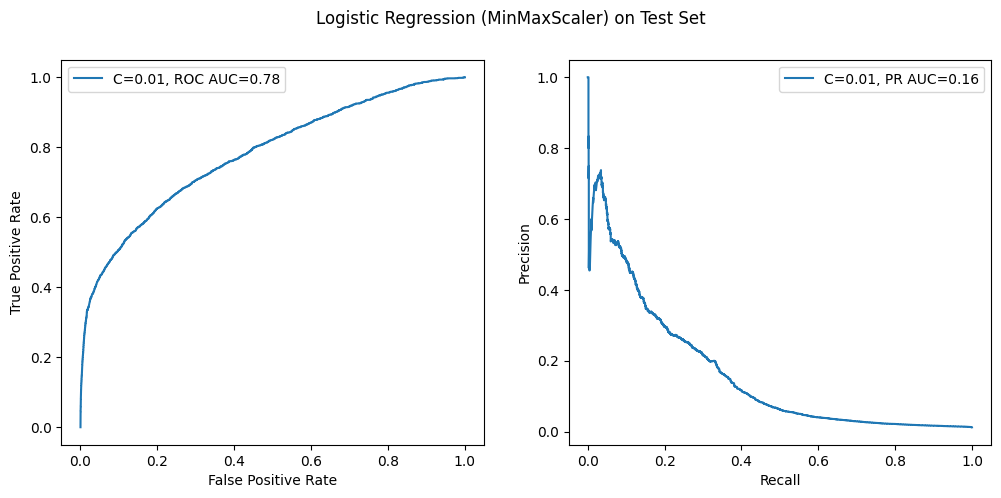

In [16]:
x_train, x_val, x_test, y_train, y_val, y_test = train_test_val_split(data)

x_train, binary_cols, categorical_cols, numerical_cols = apply_common_transformations(x_train) 
x_val, _, _, _ = apply_common_transformations(x_val)
x_test, _, _, _ = apply_common_transformations(x_test)

x_train.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                      'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_val.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                    'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_test.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                     'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)

x_train.drop(columns=categorical_cols, inplace=True)
x_val.drop(columns=categorical_cols, inplace=True)
x_test.drop(columns=categorical_cols, inplace=True) 

plt.figure(figsize=(12,5))
model = create_pipeline(c=0.01) 
model.fit(x_train, y_train)
y_test_probs = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"C={0.01}, ROC AUC={roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"C={0.01}, PR AUC={pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.suptitle("Logistic Regression (MinMaxScaler) on Test Set")
plt.show()

In [ ]:
import os
import joblib 
import git 

repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha
model_name = f'logistic_regression_{sha}.pkl'
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, model_name)
joblib.dump(model, model_path)

['../models/logistic_regression_c0.01_minmax_241a5eb9568e540772f3a642386aa1b74d4caf9a.pkl']

---

### Ejemplo de uso 

In [20]:
import importlib
import zrive.module3.data as data_mod
importlib.reload(data_mod)

import zrive.module3.inference as inference_mod
importlib.reload(inference_mod)

from zrive.module3.inference import load_model, predict

data_path = '../data/feature_frame.csv'
df = pd.read_csv(data_path)

commit_hash = '241a5eb9568e540772f3a642386aa1b74d4caf9a'
inf_test = df.iloc[:5]

model = load_model(commit_hash)
predictions = predict(model, inf_test)
predictions

/mnt/d/Escritorio/zrive/src/zrive/module3/data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['variant_id', 'order_id', 'user_id', 'created_at', 'order_date'], inplace=True)
/mnt/d/Escritorio/zrive/src/zrive/module3/data.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[
/mnt/d/Escritorio/zrive/src/zrive/module3/data.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=categori

array([0., 0., 0., 0., 0.])